In [39]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix
from math import log


# Step 1

In [40]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')

# One example
feature_test = pd.DataFrame(np.random.rand(100),  columns=['Column_A'])
feature_test_discrete = QuantileBinning(feature_test['Column_A'], 10)

def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

In [41]:
print(feature_test)
print(feature_test_discrete)

    Column_A
0   0.568558
1   0.899596
2   0.055863
3   0.802454
4   0.758138
..       ...
95  0.104353
96  0.805422
97  0.092212
98  0.150146
99  0.770979

[100 rows x 1 columns]
0     5
1     9
2     0
3     8
4     7
     ..
95    0
96    8
97    0
98    1
99    7
Name: Column_A, Length: 100, dtype: int64


In [42]:
titanic_df = pd.read_csv('Titanic.csv')

# Display the first few rows of the dataframe
titanic_df.head()
titanic_df = titanic_df.drop(["Unnamed: 0"], axis=1)
print(titanic_df.head(10))
attributes = list(titanic_df.columns)
print(attributes)
is_categorical = [True, True, True, True, False, False, False, True, False, True, True, True, False, True]
mean = dict()
std = dict()
cat_dicts = dict()
for i, attribute in enumerate(attributes):
    if not is_categorical[i]:
        titanic_df[attribute] = titanic_df[attribute].fillna(titanic_df[attribute].mean())
    else:
        cat_dicts[attribute] = dict([(attribute_name, idx) for idx,attribute_name in enumerate(set(titanic_df[attribute]))])
        titanic_df[attribute] = titanic_df[attribute].map(lambda x: cat_dicts[attribute][x])
print(titanic_df.head())
features = ["pclass", "sex", "age", "sibsp"]
feature_df = titanic_df[features]
print(feature_df)
label_df = titanic_df["survived"]
print(label_df)


# Discretization
feature_df["age"] = QuantileBinning(feature_df["age"], 20)
print(feature_df)

# Split the data into 80% training and 20% test sets
x_train, x_test, y_train, y_test = train_test_split(feature_df,label_df,random_state=10463829, test_size=0.2)
print(x_train.reset_index())

  pclass  survived                             name     sex      age  sibsp  \
0    1st         1    Allen, Miss. Elisabeth Walton  female  29.0000      0   
1    1st         1   Allison, Master. Hudson Trevor    male   0.9167      1   
2    1st         0     Allison, Miss. Helen Loraine  female   2.0000      1   
3    1st         0  Allison, Mr. Hudson Joshua Crei    male  30.0000      1   
4    1st         0  Allison, Mrs. Hudson J C (Bessi  female  25.0000      1   
5    1st         1              Anderson, Mr. Harry    male  48.0000      0   
6    1st         1  Andrews, Miss. Kornelia Theodos  female  63.0000      1   
7    1st         0           Andrews, Mr. Thomas Jr    male  39.0000      0   
8    1st         1  Appleton, Mrs. Edward Dale (Cha  female  53.0000      2   
9    1st         0          Artagaveytia, Mr. Ramon    male  71.0000      0   

   parch    ticket        fare    cabin     embarked boat   body  \
0      0     24160  211.337494       B5  Southampton    2    N

In [43]:
x_train.head(10)

,pclass,sex,age,sibsp
991,1,0,8,0
476,0,0,9,1
21,2,1,14,1
174,2,0,16,0
371,0,1,14,0
1282,1,0,8,0
331,0,0,2,0
424,0,0,9,0
1192,1,0,6,0
570,0,1,15,0


# Step 2

In [44]:
# define your entropy function and information gain function

def entropy(feature_column):
    set_entropy = 0
    value,counts = np.unique(feature_column, return_counts=True)
    probabilities = counts / len(feature_column)
    for esh in probabilities:
        set_entropy -= esh*log(esh,2)
    return set_entropy

def information_gain(train_data, target):
    total_entropy = entropy(target.value_counts(normalize=True))
    gains = {}
    
    for feature in train_data.columns:
        feature_values = train_data[feature].value_counts(normalize=True)
        set_entropy = 0
        
        for value in feature_values.index:
            conditional_set = target[train_data[feature] == value]
            conditional_entropy = entropy(conditional_set)
            set_entropy += feature_values[value] * conditional_entropy
            
        gains[feature] = total_entropy - set_entropy

    return gains

# Calculate Information Gain for each feature in the training set

info_gains = information_gain(x_train, y_train)

In [45]:
info_gains

{'pclass': 0.11911273158173907,
 'sex': 0.2671972105178593,
 'age': 0.06940926059832564,
 'sibsp': 0.0691518767055358}

So the first split should be "sex"

# Step 3

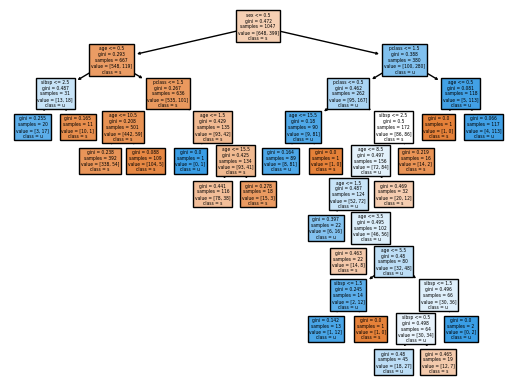

In [46]:
#from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!

# Instantiate the DecisionTreeClassifier
tree = DecisionTreeClassifier(max_leaf_nodes = 20, random_state = 10463829)



# Prepare the features and target variables for training

# Fit the decision tree model
tree.fit(x_train,y_train)

# Plot the full decision tree
plot_tree(tree, filled = True, feature_names = features, class_names = "survived")
plt.show()


In [47]:
# Define your performance metrics including accuracy, precision, recall and F1-scorre
def metrics(y_test, y_pred):
    metric = {}
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    metric["Accuracy"] = (tn + tp) / (tn + fp + fn + tp)
    metric["Precision"] = tp / (tp + fp)
    metric["Recall"] = tp / (tp + fn)
    metric["F1 Score"] = 2*metric["Precision"]*metric["Recall"]/(metric["Precision"]+metric["Recall"])
    return metric
y_pred = tree.predict(x_test)
print(metrics(y_test,y_pred))

{'Accuracy': 0.7633587786259542, 'Precision': 0.7746478873239436, 'Recall': 0.5445544554455446, 'F1 Score': 0.6395348837209304}


# Step 4

{'max_leaf_nodes': 10}


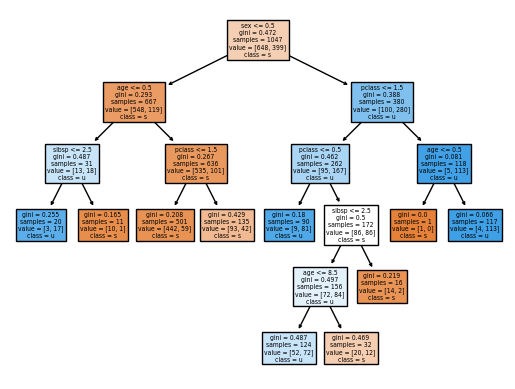

Performance Metrics:  {'Accuracy': 0.7595419847328244, 'Precision': 0.7435897435897436, 'Recall': 0.5742574257425742, 'F1 Score': 0.64804469273743}


In [48]:
#from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=10463829), param_grid, cv=5)
grid_search.fit(x_train, y_train) # Note testing set cannot be used

# Get the best estimator with the optimal max_leaf_nodes parameter
best_parameters = grid_search.best_params_
print(best_parameters)
best_tree = grid_search.best_estimator_


# Plot the pruned decision tree
plot_tree(best_tree, filled = True, feature_names = features, class_names = "survived")
plt.show()

y_pred = best_tree.predict(x_test)

print("Performance Metrics: ", metrics(y_test,y_pred))


# Step 5


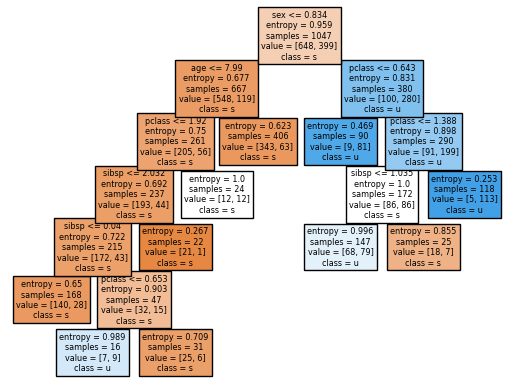

Performance Metrics:  {'Accuracy': 0.7290076335877863, 'Precision': 0.6744186046511628, 'Recall': 0.5742574257425742, 'F1 Score': 0.6203208556149732}


In [54]:
## it's an example (max_depth)

dt_opt_critia = DecisionTreeClassifier(max_leaf_nodes = 10, criterion = "entropy", splitter = "random", random_state=10463829)
dt_opt_critia.fit(x_train, y_train) 


plot_tree(dt_opt_critia, filled = True, feature_names = features, class_names = "survived")
plt.show()

y_pred = dt_opt_critia.predict(x_test)

print("Performance Metrics: ", metrics(y_test,y_pred))


{'max_depth': 5}


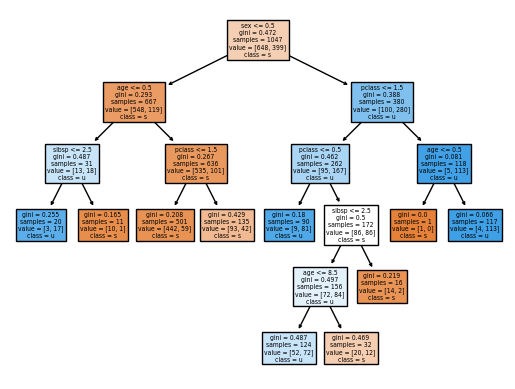

Performance Metrics:  {'Accuracy': 0.7595419847328244, 'Precision': 0.7435897435897436, 'Recall': 0.5742574257425742, 'F1 Score': 0.64804469273743}


In [53]:
param_grid = {'max_depth': list(range(1, 50))}

grid_search = GridSearchCV(DecisionTreeClassifier(max_leaf_nodes = 10, random_state=10463829), param_grid, cv=5)
grid_search.fit(x_train, y_train) 

best_parameters = grid_search.best_params_
print(best_parameters)
dt_max_depth = grid_search.best_estimator_


plot_tree(dt_max_depth, filled = True, feature_names = features, class_names = "survived")
plt.show()

y_pred = dt_max_depth.predict(x_test)

print("Performance Metrics: ", metrics(y_test,y_pred))

In [51]:
def ensemble_vote(models, X):
    
    # Perform majority vote
    # For each sample, count the votes for each class (0 or 1)

    # Determine the winning class for each sample: it's the one with the most votes
    # If there's a tie, we choose the class with the highest index (1 in this case)
    predictions = []
    ensemble_predictions = []
    for esh in models:
        predictions.append(esh.predict(X))
    for esh in range(len(predictions[0])):
        prediction_sum = 0
        for model in range(len(models)):
            prediction_sum += predictions[model][esh]
            
        ensemble_predictions.append(round(prediction_sum / len(models)))
        
    return ensemble_predictions

# Use the defined function to get predictions from the ensemble of the three trees
models = [best_tree, dt_max_depth, dt_opt_critia]
ensemble_predictions = ensemble_vote(models, x_test)
# Calculate performance metrics for the ensemble using the previously defined function
print("Performance Metrics: ", metrics(y_test,ensemble_predictions))

Performance Metrics:  {'Accuracy': 0.7557251908396947, 'Precision': 0.7228915662650602, 'Recall': 0.594059405940594, 'F1 Score': 0.6521739130434783}


In [55]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest
rf = RandomForestClassifier(n_estimators = 50, max_leaf_nodes = 10, max_depth = 5)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print("Performance Metrics: ", metrics(y_test,y_pred))

Performance Metrics:  {'Accuracy': 0.7519083969465649, 'Precision': 0.7195121951219512, 'Recall': 0.5841584158415841, 'F1 Score': 0.644808743169399}


Based on the performance metrics, random forrest performs slightly worse than custom ensemble method. Therefore based on the dataset you can determine what is more important. However in practice the results appear to be negligible and both will likley perform within margin of error on a seperate test dataset. The reason for the similarity can be as follows. The dataset is not very complex so the 3 decision trees that were constructed by optimizing different parameters were able to utilize the provided data to the fullest extend that a decision tree occured, especially since the best parameters were passed onto the next tree. Therefore even though the random forrest uses 50 estimators, many of them are worse and do not help in this case. Not that many estimators are needed. This would be different if there was more data and more features to be utilized for optimization. I would suspect that the more complex a dataset becomes the more likley random forrest classifier would perform better than a custom ensemble method with 3 optimized trees. 